In [1]:
%reload_ext autoreload
%autoreload 2
import sys  
sys.path.insert(1, 'functions/')
from statistics_functions import *
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import cartopy.crs as ccrs
import cartopy

# Analyzing the Weekly Data, Comparing different DoG Thresholds

In [3]:
base_path  = '/work/bk1377/a270230/'
path_ds    = base_path + 'lkf_datasets/weekly_data/'
path_ice   = base_path + 'interpolated_fesom_output/'

files = os.listdir(path_ds)
files.sort()
files.remove('.ipynb_checkpoints')
files

['ds_2013_d0.01.npy',
 'ds_2013_d0.05.npy',
 'ds_2013_d0.1.npy',
 'ds_2013_d0.2.npy',
 'ds_2013_d0.25.npy',
 'ds_2013_d0.5.npy',
 'ds_2013_d1.0.npy']

In [3]:
years, dogs = [], []
for file in files:
    years.append(file.split('_')[1].split('.')[0])
    dogs.append(file.split('_')[2][1:-4])

In [4]:
# get the lkf_data objects
datasets = []
for file in files:
    datasets.append(np.load(path_ds + file, allow_pickle=True)[0])

In [5]:
# get the lkf data in arrays for every timestep
lkfs_all = []
for lkf_data in datasets:
    lkfs_all.append(get_lkfs_all(lkf_data))

In [6]:
# calculate the total ice area (in km2) at every time step
ice_coverage, ice_coverage_weekly = get_ice_coverage(years, path_ice)

In [7]:
# get the number of lkfs at each timestep
n_lkfs = []
for lkfs_all_dataset in lkfs_all:
    n_lkfs.append(get_n_lkfs(lkfs_all_dataset))
    
# get the number of lkfs per ice covered area at every timestep
lkf_density = [[] for _ in years]
for year in range(len(years)):
    lkf_density[year] = np.array(n_lkfs[year]) / np.array(ice_coverage_weekly[year])

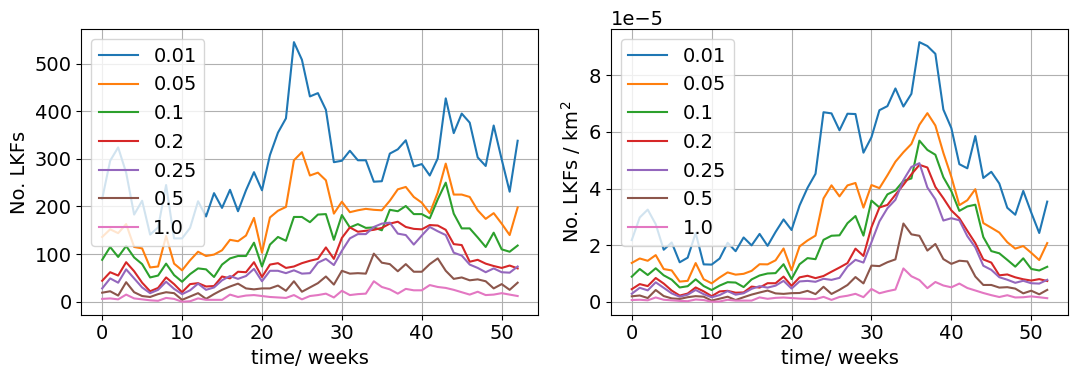

In [8]:
plot_num_LKFs(dogs, n_lkfs, lkf_density, 'time/ weeks')

In [9]:
# get the length of every LKF as well as the average
# LKF length in pixels at every timestep
lkf_len = []
av_lkf_len = []
for lkfs_all_dataset in lkfs_all:
    lkf_len.append(get_lkf_len(lkfs_all_dataset)[0])
    av_lkf_len.append(get_lkf_len(lkfs_all_dataset)[1])

/home/a/a270230/miniconda3/envs/lkf_tools/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/a/a270230/miniconda3/envs/lkf_tools/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


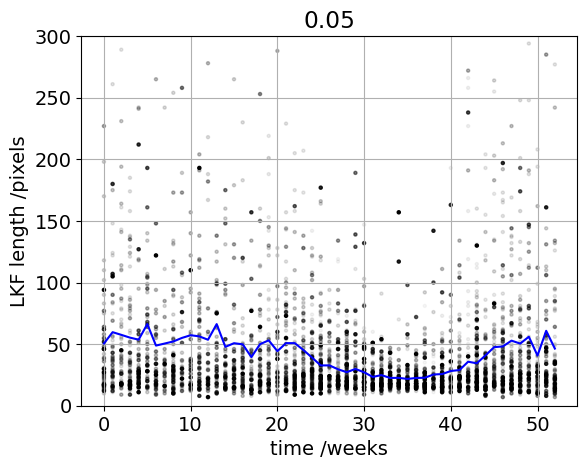

In [10]:
ind = 1
ylim = 300
plot_lkf_length(ind, ylim, lkf_len, av_lkf_len, dogs, 'LKF length /pixels', 'time /weeks')

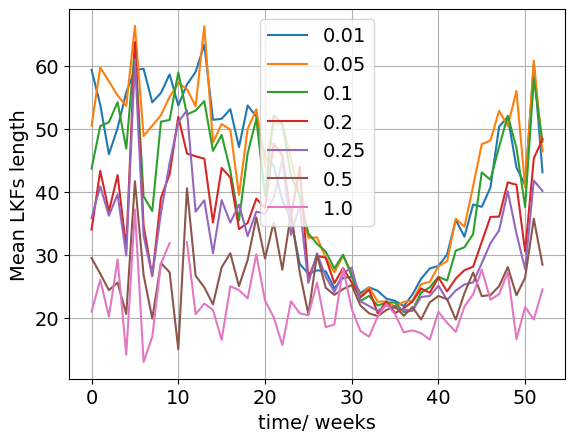

In [11]:
for dog, lkf_len in zip(dogs, av_lkf_len):
    plt.plot(lkf_len, label=dog)
    
plt.grid()
plt.xlabel('time/ weeks')
plt.ylabel('Mean LKFs length')
plt.legend()

# Calculate metrics for 2010s and 2090s

In [2]:
base_path  = '/work/bk1377/a270230/'
path_ds    = base_path + 'lkf_datasets/daily_data/'
path_ice   = base_path + 'interpolated_fesom_output/'
path_out   = base_path + 'data_transfer/'

files = os.listdir(path_ds)
files.sort()
files.remove('.ipynb_checkpoints')
files.remove('fesom_ifs')
files

['ds_2013.npy',
 'ds_2014.npy',
 'ds_2015.npy',
 'ds_2016.npy',
 'ds_2020.npy',
 'ds_2093.npy',
 'ds_2096.npy',
 'ds_2099.npy']

In [3]:
years = [2013, 2016, 2020, 2093, 2096, 2099]

In [4]:
%%time
# calculate the total ice area (in km2) at every time step
ice_coverage, ice_coverage_weekly = get_ice_coverage(years, path_ice)

# get the lkf_data objects
datasets = []
for year in years:
    datasets.append(np.load(path_ds + f'ds_{year}.npy', allow_pickle=True)[0])

# get the lkf data as array for every timestep
lkfs = []
for lkf_data in datasets:
    lkfs.append(get_lkfs_all(lkf_data)[:365])

# get the tracks for every timestep
tracks = []
for lkf_data in datasets:
    tracks.append(get_tracks_all(lkf_data))

# get the lkf paths starting at each timestep
paths = []
for lkfs_all_dataset, tracks_all_dataset in zip(lkfs, tracks):
    paths.append(get_lkf_paths(lkfs_all_dataset, tracks_all_dataset))

CPU times: user 36.3 s, sys: 5.63 s, total: 41.9 s
Wall time: 43.6 s


In [5]:
np.save(path_out + 'data_lkfs_paths.npy', np.array([years, ice_coverage, lkfs, paths], dtype='object'), allow_pickle=True)

In [6]:
[years, ice_coverage, lkfs, paths] = np.load(path_out + 'data_lkfs_paths.npy', allow_pickle=True)

In [7]:
# get the number of lkfs at each timestep
n_lkfs = []
for lkfs_all_dataset in lkfs:
    n_lkfs.append(get_n_lkfs(lkfs_all_dataset))

# get the number of lkfs per ice covered area at every timestep,
# the scaling is 1/ (100km * 100km)
rho_lkfs = [[] for _ in years]
for year in range(len(years)):
    rho_lkfs[year] = np.array(n_lkfs[year]) / np.array(ice_coverage[year]) * 10000

# get the length of every LKF as well as the average
# LKF length in pixels at every timestep
lkf_len, av_lkf_len, total_lkf_len = [], [], []
for lkfs_all_dataset in lkfs:
    a, b, c = get_lkf_len(lkfs_all_dataset)
    lkf_len.append(a)
    av_lkf_len.append(b)
    total_lkf_len.append(c)

# get the lifetime of the lkf paths and their mean as well as
# the mean of only the paths that are longer than one day
lifetimes, mean_lifetime, mean_lifetime_tracked_lkfs = [], [], []
for lkf_paths_dataset in paths:
    a, b, c = get_lifetimes(lkf_paths_dataset)
    lifetimes.append(a)
    mean_lifetime.append(b)
    mean_lifetime_tracked_lkfs.append(c)

/tmp/ipykernel_374870/3358035515.py:10: RuntimeWarning: invalid value encountered in divide
  rho_lkfs[year] = np.array(n_lkfs[year]) / np.array(ice_coverage[year]) * 10000
/home/a/a270230/LKF/lkf_detection/functions/statistics_functions.py:64: RuntimeWarning: Mean of empty slice
  av_lkf_len.append(np.nanmean(lkf_len[timestep]))
/home/a/a270230/LKF/lkf_detection/functions/statistics_functions.py:177: RuntimeWarning: Mean of empty slice.
  mean_lifetime.append(lifetimes_timestep.mean())
/home/a/a270230/miniconda3/envs/lkf_tools/lib/python3.11/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount
/home/a/a270230/LKF/lkf_detection/functions/statistics_functions.py:187: RuntimeWarning: Mean of empty slice.
  mean_lifetime_tracked_lkfs.append(lifetimes_tracked_lkfs_timestep.mean())


# Plot one individual year

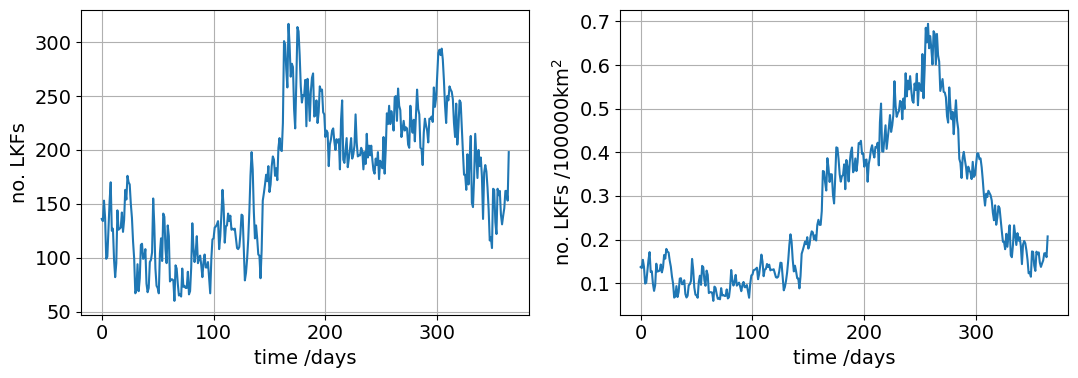

In [8]:
year = 2013

i = np.where(years==year)[0][0]

fig, axs = plt.subplots(1,2, figsize=(11,4))

for ax, data, ylabel in zip(
    axs, [n_lkfs[i], rho_lkfs[i]], ['no. LKFs', 'no. LKFs /100000km$^2$']
):
    
    ax.plot(data)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('time /days')
    ax.grid()

fig.tight_layout()

In [9]:
# show the first matching pairs at each day
tracks_all_dataset = tracks[0]
print('\n'.join(['   \t'.join([str(tracks_all_dataset[day][lkf]).replace('[ ','[').replace('[ ','[') for day in range(7)]) for lkf in range(10)]))

[0 0]   	[0 1]   	[1 0]   	[0 0]   	[0 94]   	[1 21]   	[0 0]
[0 7]   	[4 7]   	[1 6]   	[7 5]   	[1 1]   	[1 28]   	[1 2]
[1 2]   	[5 141]   	[9 10]   	[8 1]   	[2 4]   	[4 1]   	[2 3]
[7 15]   	[6 5]   	[10 13]   	[10 26]   	[7 13]   	[7 116]   	[2 8]
[9 4]   	[7 1]   	[11 127]   	[16 17]   	[15 97]   	[14 12]   	[2 23]
[11 17]   	[13 12]   	[13 16]   	[18 96]   	[21 25]   	[22 23]   	[8 135]
[12 19]   	[14 11]   	[13 19]   	[20 27]   	[22 23]   	[23 23]   	[11 14]
[18 21]   	[15  9]   	[17 20]   	[21 28]   	[26  7]   	[24  2]   	[14 19]
[21 22]   	[16  2]   	[18 21]   	[29 35]   	[28 30]   	[25 24]   	[15 22]
[23 28]   	[19 14]   	[22 23]   	[33 40]   	[31 35]   	[28 16]   	[15 151]


# Compare individual years

In [10]:
years

array([2013, 2016, 2020, 2093, 2096, 2099], dtype=object)

In [11]:
def compare_scatter(data, mean, ylabel, ylim):
    i = 0
    j = 3
    d = 151

    fig, axs = plt.subplots(1,2, figsize=(11,4))

    for ax, data, mean, title in zip(
        axs, [data[i][:d], data[j][:d]], [mean[i][:d], mean[j][:d]], [years[i], years[j]]
    ):

        for timestep, lkf_len_timestep in enumerate(data):

            try:
                frequency = np.zeros(int(np.max(lkf_len_timestep)+1))
                for lkf_len_i in lkf_len_timestep:
                    frequency[lkf_len_i] += 1

                f_norm = frequency/frequency.max()
            except:
                f_norm = 0

            ax.scatter(timestep * np.ones_like(lkf_len_timestep), lkf_len_timestep, s=5, c='k', alpha=f_norm)

        ax.plot(mean, 'b')
        ax.grid()
        ax.set_xlabel('time /days')
        ax.set_ylabel(ylabel)
        ax.set_ylim([0,ylim])
        ax.set_title(title)

    fig.tight_layout()

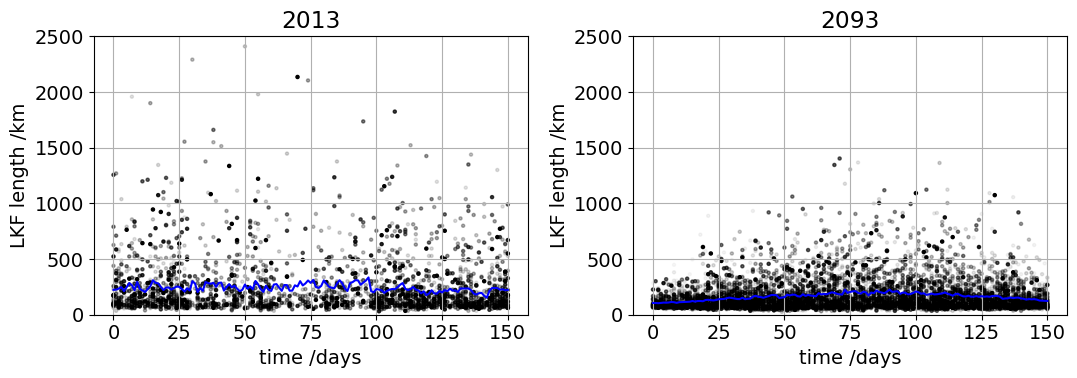

In [12]:
compare_scatter(lkf_len, av_lkf_len, 'LKF length /km', 2500)

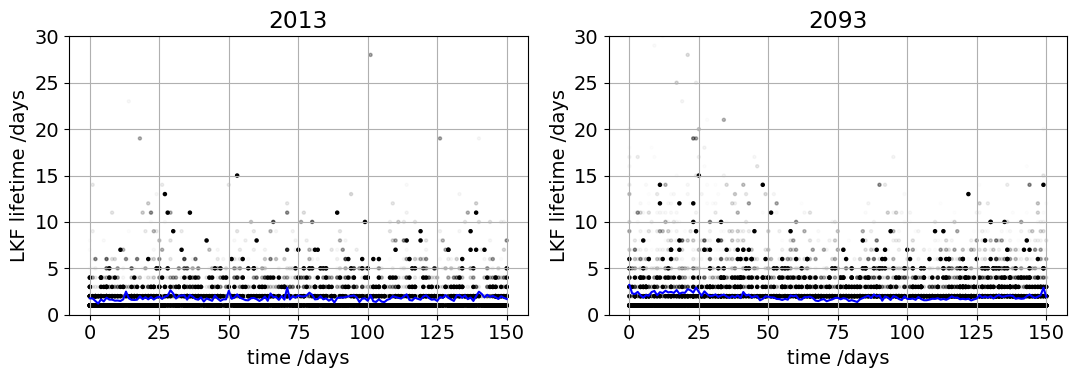

In [13]:
compare_scatter(lifetimes, mean_lifetime, 'LKF lifetime /days', 30)

# Compare 2010s with 2090s

In [14]:
i = 3

#####

n_lkfs_av = np.mean(n_lkfs[:i], axis=0)
n_lkfs_sd = np.sqrt(np.var(n_lkfs[:i], axis=0))

rho_lkfs_av = np.mean(rho_lkfs[:i], axis=0)
rho_lkfs_sd = np.sqrt(np.var(rho_lkfs[:i], axis=0))

n_lkfs_90_av = np.mean(n_lkfs[i:], axis=0)
n_lkfs_90_sd = np.sqrt(np.var(n_lkfs[i:], axis=0))

rho_lkfs_90_av = np.mean(rho_lkfs[i:], axis=0)
rho_lkfs_90_sd = np.sqrt(np.var(rho_lkfs[i:], axis=0))

#####

mean_lkf_len_av = np.mean(av_lkf_len[:i], axis=0)
mean_lkf_len_sd = np.sqrt(np.var(av_lkf_len[:i], axis=0))

total_lkf_len_av =  np.mean(total_lkf_len[:i], axis=0)
total_lkf_len_sd = np.sqrt(np.var(total_lkf_len[:i], axis=0))

mean_lkf_len_90_av = np.mean(av_lkf_len[i:], axis=0)
mean_lkf_len_90_sd = np.sqrt(np.var(av_lkf_len[i:], axis=0))

total_lkf_len_90_av =  np.mean(total_lkf_len[i:], axis=0)
total_lkf_len_90_sd = np.sqrt(np.var(total_lkf_len[i:], axis=0))

#####

mean_lkf_lt_av = np.mean(mean_lifetime[:i], axis=0)
mean_lkf_lt_sd = np.sqrt(np.var(mean_lifetime[:i], axis=0))

mean_lkf_lt_90_av = np.mean(mean_lifetime[i:], axis=0)
mean_lkf_lt_90_sd = np.sqrt(np.var(mean_lifetime[i:], axis=0))

In [15]:
def compare(av, av_90, sd, sd_90, ylabel, ylim):
    j = 151

    fig, axs = plt.subplots(1,2, figsize=(11,4))

    for ax, data, var, title in zip(
        axs, [av[:j], av_90[:j]], [sd[:j], sd_90[:j]], ['2013 - 2020', '2093 - 2100']
    ):

        ax.plot(data)
        ax.fill_between(np.arange(j), data+var, data-var, alpha=0.5)
        ax.set_ylabel(ylabel)
        ax.set_xlabel('time /days')
        ax.set_ylim([0,ylim])
        ax.set_title(title)
        ax.grid()

    fig.tight_layout()

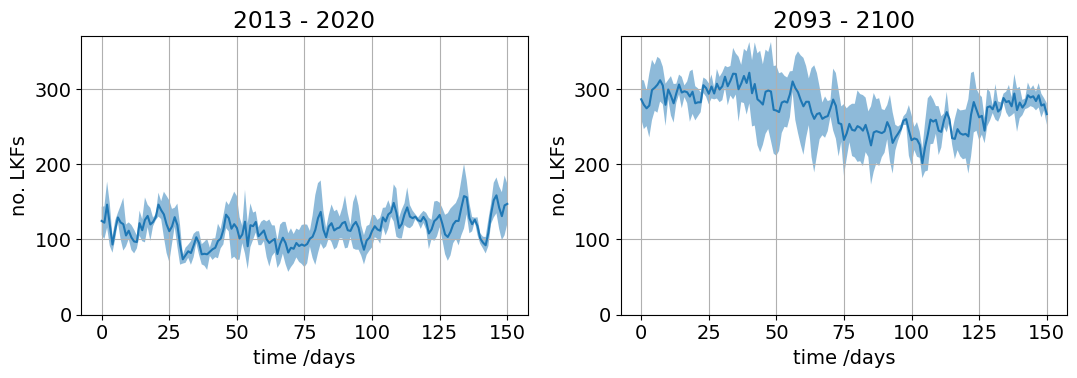

In [16]:
compare(n_lkfs_av, n_lkfs_90_av, n_lkfs_sd, n_lkfs_90_sd, 'no. LKFs', 370)

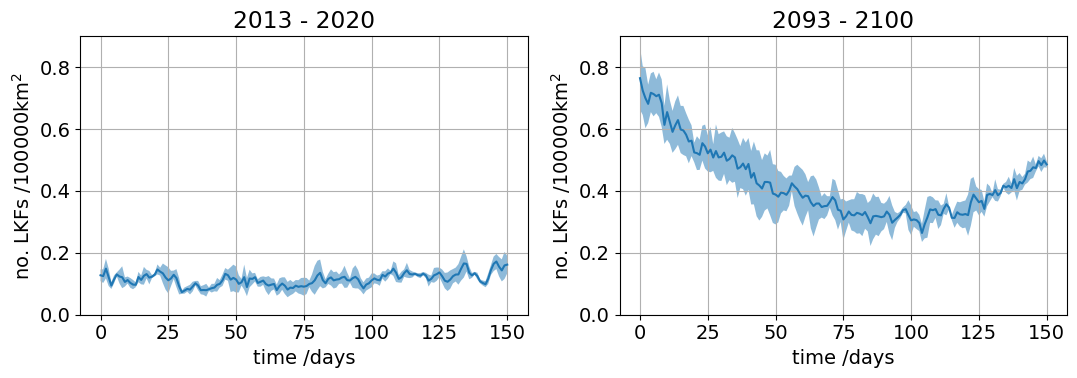

In [17]:
compare(rho_lkfs_av, rho_lkfs_90_av, rho_lkfs_sd, rho_lkfs_90_sd, 'no. LKFs /100000km$^2$', 0.9)

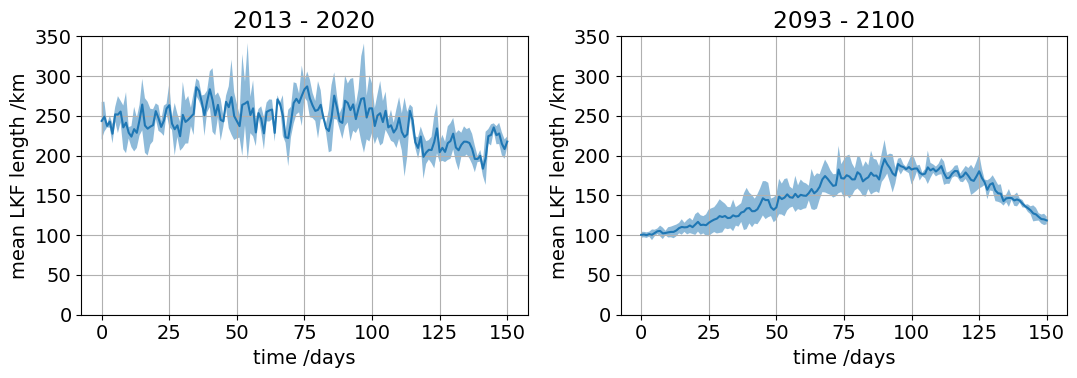

In [18]:
compare(mean_lkf_len_av, mean_lkf_len_90_av, mean_lkf_len_sd, mean_lkf_len_90_sd, 'mean LKF length /km', 350)

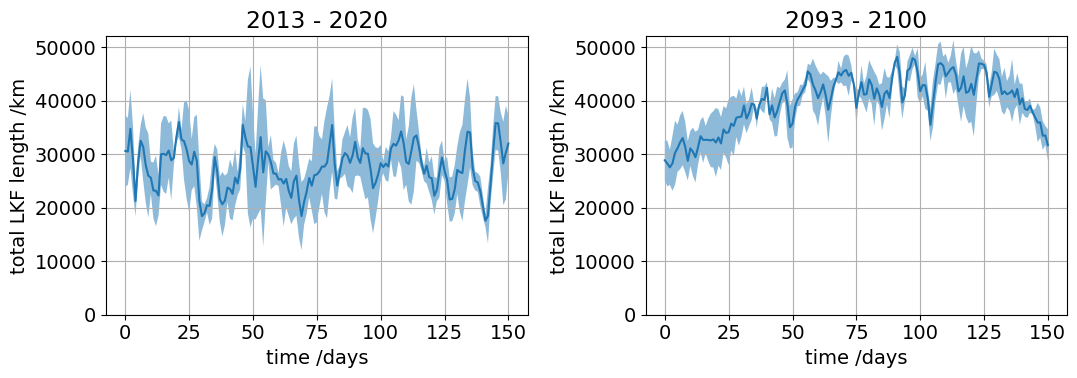

In [19]:
compare(total_lkf_len_av, total_lkf_len_90_av, total_lkf_len_sd, total_lkf_len_90_sd, 'total LKF length /km', 52000)

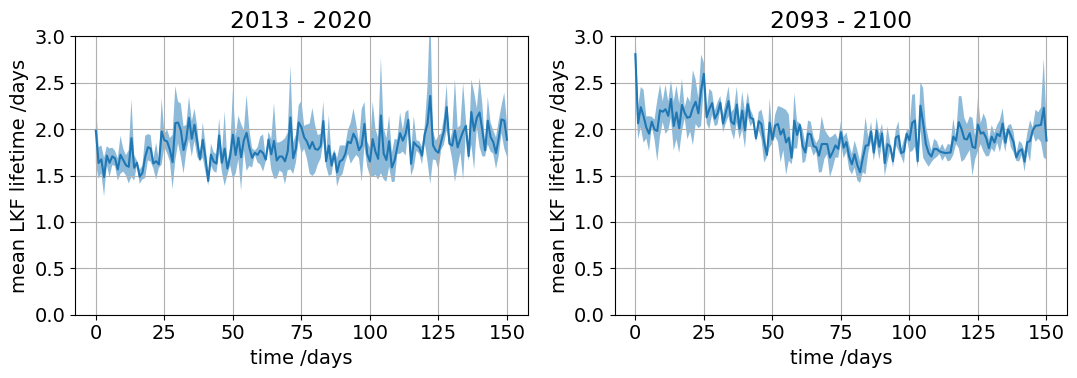

In [20]:
compare(mean_lkf_lt_av, mean_lkf_lt_90_av, mean_lkf_lt_sd, mean_lkf_lt_90_sd, 'mean LKF lifetime /days', 3)

# Calculate LKF Frequency

In [21]:
years = [2013, 2016, 2020, 2093, 2096, 2099]

In [22]:
# get the lkf_data objects
datasets = []
for year in years:
    datasets.append(np.load(path_ds + f'ds_{year}.npy', allow_pickle=True)[0])

In [23]:
mask = np.where(np.isnan(datasets[0].calc_eps_tot(0)), np.nan, 1)

coarse_grid_box_size_km = 50

In [24]:
%%time
d = 151

LKFs_f = []
for lkf_data in datasets:
    
    LKFs_f_tmp = np.zeros_like(mask)
    for i in range(d):
        LKFs_f_tmp += coarse_graining(lkf_data.finetuning(ind=i, dog_thres=0.05, plot=False), coarse_grid_box_size_km)

    LKFs_f_tmp *= mask

    LKFs_f.append(LKFs_f_tmp / d)

/home/a/a270230/LKF/lkf_tools/lkf_tools/detection.py:100: RuntimeWarning: invalid value encountered in divide
  gaussian_field = field_nonnan_f/mask_nan_f
/home/a/a270230/LKF/lkf_tools/lkf_tools/dataset.py:388: RuntimeWarning: Mean of empty slice
  eps_tot = np.nanmean(np.stack(eps_tot),axis=0)


CPU times: user 1min 56s, sys: 3.9 s, total: 2min
Wall time: 2min 39s


In [27]:
np.save(base_path + 'data_transfer/LKFs_f_50', LKFs_f)

In [28]:
LKFs_f = np.load(base_path + 'data_transfer/LKFs_f.npy')

In [29]:
i = 3

LKFs_f_av = np.mean(LKFs_f[:i], axis=0)
LKFs_f_sd = np.sqrt(np.var(LKFs_f[:i], axis=0))

LKFs_f_90_av = np.mean(LKFs_f[i:], axis=0)
LKFs_f_90_sd = np.sqrt(np.var(LKFs_f[i:], axis=0))

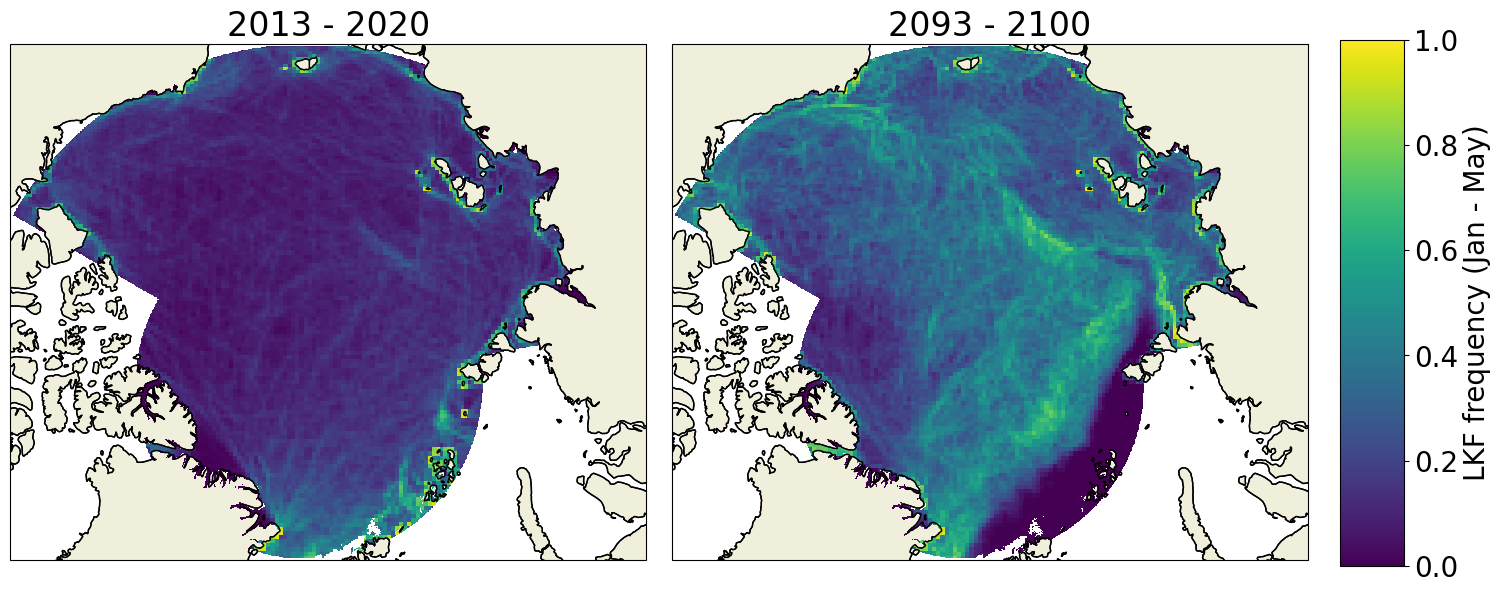

In [30]:
fig = plt.figure(figsize=[16, 8])
plt.rcParams.update({'font.size':20})

for col, data, title in zip([1,2], [LKFs_f_av, LKFs_f_90_av], ['2013 - 2020', '2093 - 2100']):

    ax = plt.subplot(1, 2, col, projection=ccrs.Orthographic(0, 90))

    ax.coastlines(zorder=3)
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

    it = lkf_data.indexes[0]

    pcm = ax.pcolormesh(lkf_data.lon[max([0,lkf_data.index_y[0][0]-1]):lkf_data.index_y[0][-1]+2:lkf_data.red_fac,
                           max([0,lkf_data.index_x[0][0]-1]):lkf_data.index_x[0][-1]+2:lkf_data.red_fac],
                  lkf_data.lat[max([0,lkf_data.index_y[0][0]-1]):lkf_data.index_y[0][-1]+2:lkf_data.red_fac,
                           max([0,lkf_data.index_x[0][0]-1]):lkf_data.index_x[0][-1]+2:lkf_data.red_fac],
                  data,transform=ccrs.PlateCarree(),vmin=0,vmax=1)
    ax.set_title(title)
    
fig.tight_layout()
fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.17, 0.04, 0.658])
cbar = fig.colorbar(pcm, cax=cbar_ax)
cbar.set_label('LKF frequency (Jan - May)')

#plt.savefig(imgs_path + 'comp_f_lfks.png', dpi=200, bbox_inches='tight')

In [31]:
rel_diff = (LKFs_f[2] - LKFs_f[0]) / LKFs_f[0]
rel_diff_90 = (LKFs_f[5] - LKFs_f[3]) / LKFs_f[3]

/tmp/ipykernel_374870/2714090029.py:1: RuntimeWarning: divide by zero encountered in divide
  rel_diff = (LKFs_f[2] - LKFs_f[0]) / LKFs_f[0]
/tmp/ipykernel_374870/2714090029.py:1: RuntimeWarning: invalid value encountered in divide
  rel_diff = (LKFs_f[2] - LKFs_f[0]) / LKFs_f[0]
/tmp/ipykernel_374870/2714090029.py:2: RuntimeWarning: divide by zero encountered in divide
  rel_diff_90 = (LKFs_f[5] - LKFs_f[3]) / LKFs_f[3]
/tmp/ipykernel_374870/2714090029.py:2: RuntimeWarning: invalid value encountered in divide
  rel_diff_90 = (LKFs_f[5] - LKFs_f[3]) / LKFs_f[3]


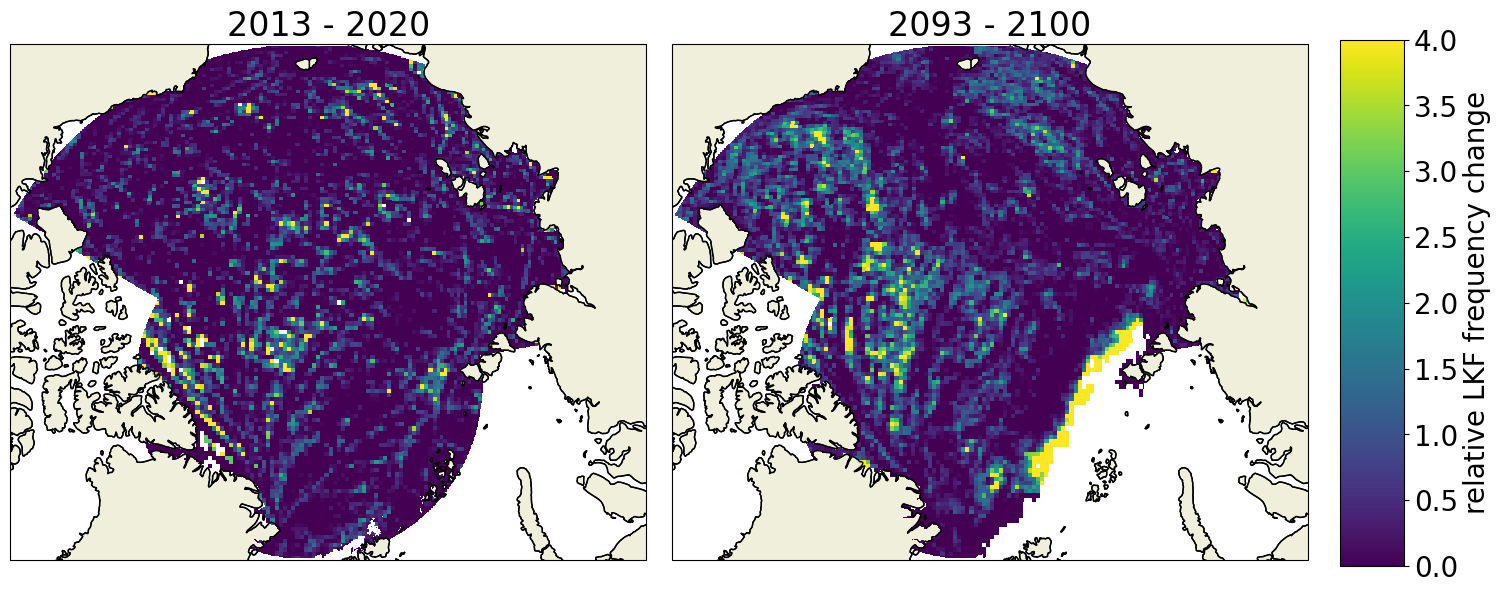

In [32]:
fig = plt.figure(figsize=[16, 8])
plt.rcParams.update({'font.size':20})

for col, data, title in zip([1,2], [rel_diff, rel_diff_90], ['2013 - 2020', '2093 - 2100']):

    ax = plt.subplot(1, 2, col, projection=ccrs.Orthographic(0, 90))

    ax.coastlines(zorder=3)
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

    it = lkf_data.indexes[0]

    pcm = ax.pcolormesh(lkf_data.lon[max([0,lkf_data.index_y[0][0]-1]):lkf_data.index_y[0][-1]+2:lkf_data.red_fac,
                           max([0,lkf_data.index_x[0][0]-1]):lkf_data.index_x[0][-1]+2:lkf_data.red_fac],
                  lkf_data.lat[max([0,lkf_data.index_y[0][0]-1]):lkf_data.index_y[0][-1]+2:lkf_data.red_fac,
                           max([0,lkf_data.index_x[0][0]-1]):lkf_data.index_x[0][-1]+2:lkf_data.red_fac],
                  data,transform=ccrs.PlateCarree(),vmin=0,vmax=4)
    ax.set_title(title)
    
fig.tight_layout()
fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.17, 0.04, 0.658])
cbar = fig.colorbar(pcm, cax=cbar_ax)
cbar.set_label('relative LKF frequency change')

#plt.savefig(imgs_path + 'comp_f_lfks.png', dpi=200, bbox_inches='tight')